In [ ]:
import pandas as pd
import unidecode
import re
import numpy as np
from itertools import product

from nltk.tokenize import word_tokenize
import time

pd.options.display.float_format = '{:.2f}'.format

ALGUMAS FUNÇÕES AUXILIARES DE PRÉ-PROCESSAMENTO

In [ ]:
def get_numero(text):
    text = str(text)
    text = text.upper()
    i = text.find('BOA VIAGEM')
    if i != -1:
        text = text[:i]
    
    non_numbers = re.compile('[^0-9]')
    number = re.sub(non_numbers, '', text)
        
    return number

def replace_R_by_RUA(rua):
    rua = str(rua)
    rua = rua.upper().strip()
    if rua.find('R ') == 0:
        rua = rua.replace('R ', 'RUA ')
    
    return rua
    

def get_rua(text):
    text = str(text)
    rua = text.split(sep = ',')[0].strip().upper()
    rua = unidecode.unidecode(rua)
    rua = re.sub("[0-9]", "", rua)
    rua = re.sub('\s+',' ', rua)
    return rua

def remover_caracteres_especiais_e_acentuacao(texto):
    texto = str(texto)
    texto = unidecode.unidecode(texto)
    texto = texto.upper()
    texto = texto.replace('Ç', 'C')
    texto = re.sub('[^A-Za-z0-9]+', ' ', texto).strip()
    texto = re.sub('\s+',' ', texto)
    if (texto == '') or (texto == 'NAN') or (texto == 'EDF'):
        texto = 'NAO_INFORMADO'
    return texto

Tratamento de termos homófonos

In [ ]:
def get_par(nome, homofonos_pares):
    result = []
    for par in homofonos_pares:
        if nome in par:
            result = par
            break
    
    return result


def get_homofonos(rua):
    
    rua = str(rua)
    
    homofonos_pares = [['LUIS', 'LUIZ'], ['ARTHUR', 'ARTUR'], ['MELO', 'MELLO'], ['SOUZA', 'SOUSA'],
                       ['TERESA', 'TEREZA'], ['CRISTINA', 'CHRISTINA'], ['MORAIS', 'MORAES'], 
                       ['CORREIA', 'CORREA'], ['FARIA', 'FARIAS'], ['BARBOSA', 'BARBOZA']]
    homofonos = []

    ruas_possiveis = []


    for par in homofonos_pares:
        homofonos.extend(par)


    rua_tokens =  word_tokenize(rua)

    i = 0
    for termo in rua_tokens:
        if termo in homofonos:
            par = get_par(termo, homofonos_pares)
            rua_tokens[i] = par
        else:
            rua_tokens[i] = [termo]
        i = i + 1

    result = list(product(*rua_tokens))
    for item in result:
        x = ' '.join([x for x in item])
        ruas_possiveis.append(x)

    return ruas_possiveis

## Leitura de dados

DADOS ESIG RECIFE

In [29]:
data_set_esig = pd.read_excel('esig_data_base.xlsx')


In [30]:
data_set_esig['Endereco'] = data_set_esig['Endereco'].str.upper()
data_set_esig['Rua'] = data_set_esig['Rua'].str.upper()
data_set_esig['Rua'] = data_set_esig['Rua'].apply(remover_caracteres_especiais_e_acentuacao)
data_set_esig['Numero'] = [num.replace('.0', '') for num in data_set_esig['Numero'].apply(str)]


In [ ]:
data_set_esig.describe()

In [ ]:
data_set_esig.info()

DADOS APARTAMENTOS - VENDA

In [31]:
data_aptos = pd.read_excel('aptos_2022_maior.xlsx')

data_aptos.drop(columns=['sala_comercial', 'área total'], inplace=True)

In [32]:
data_aptos_2019 = pd.read_excel('aptos_2019.xlsx')

## Pré-processamento dados apartamentos

Inserção do ano de coleta da informação como atributo dos datasets.

In [33]:
data_aptos['ano_oferta'] = 2022
data_aptos_2019['ano_oferta'] = 2019

Concatenação dos dados de 2019 ao dataset de 2022.

In [34]:
data_aptos = pd.concat([data_aptos, data_aptos_2019], ignore_index=True)

Manipulação de strings para padronização de campos textuais úteis.

In [35]:
data_aptos['endereco'] = data_aptos.endereco.str.upper()
data_aptos['anunciante'] = data_aptos['anunciante'].str.upper()
data_aptos['anunciante'] = data_aptos['anunciante'].apply(remover_caracteres_especiais_e_acentuacao)

Inserção de id como atributo.

In [36]:
id = [i for i in range(1, len(data_aptos) + 1)]
data_aptos['id'] = id

Extraindo o número do prédio, como atributo, a partir do endereço.

In [37]:
data_aptos['Numero'] = data_aptos.endereco.apply(get_numero)

In [ ]:
data_aptos.columns

In [ ]:
data_aptos.describe()

Padronização de termos e abreviações comuns em endereços.

In [38]:
data_aptos['endereco'] = data_aptos.endereco.str.replace('ENDEREÇO:', '', regex = False)
data_aptos['endereco'] = data_aptos.endereco.str.replace('DR.', 'DOUTOR', regex = False)
data_aptos['endereco'] = data_aptos.endereco.str.replace('R.', 'RUA', regex = False)
data_aptos['endereco'] = data_aptos.endereco.str.replace('AV.', 'AVENIDA', regex = False)
data_aptos['endereco'] = data_aptos.endereco.str.replace('AV ', 'AVENIDA ', regex = False)
data_aptos['endereco'] = data_aptos.endereco.str.replace('DR ', 'DOUTOR ', regex = False)
data_aptos['endereco'] = data_aptos.endereco.str.replace('PROF.', 'PROFESSOR', regex = False)
data_aptos['endereco'] = data_aptos.endereco.str.replace('VISC.', 'VISCONDE', regex = False)
data_aptos['endereco'] = data_aptos.endereco.str.replace('AVENIDA VISCONDE DE JEQUITINHONHA', 
                                                         'RUA VISCONDE DE JEQUITINHONHA', 
                                                         regex = False)

data_aptos['endereco'] = data_aptos.endereco.apply(replace_R_by_RUA)

data_set_esig['Endereco'] = data_set_esig['Endereco'].str.replace('DR ', 'DOUTOR ', regex = False)
data_set_esig['Rua'] = data_set_esig['Rua'].str.replace('DR ', 'DOUTOR ', regex = False)

Concatenar 'Rua' e 'Numero' para criar a chave de busca 'Rua_Numero'.

In [39]:
data_aptos['Rua'] = data_aptos.endereco.apply(get_rua)
data_aptos['Rua_Numero'] = data_aptos[['Rua', 'Numero']].agg(' '.join, axis=1).str.strip()

data_set_esig['Rua_Numero'] = data_set_esig[['Rua', 'Numero']].agg(' '.join, axis=1).str.strip()

Remover dados sem área útil informada

In [40]:
len_antes = len(data_aptos)
data_aptos = data_aptos[data_aptos['área útil'].notnull()].copy()
len_depois = len(data_aptos)
print('Antes: ', len_antes)
print('Depois: ', len_depois)
print('Removidos: ', len_antes - len_depois)

Antes:  4488
Depois:  4377
Removidos:  111


## Base Esig Recife

In [41]:
data_esig_boa_viagem = data_set_esig[data_set_esig['Bairro'] == 'Boa Viagem'].copy()
len(data_esig_boa_viagem)

4544

Filtrando as tipologias residenciais 'Condomínio Misto', 
'Condomínio Residencial', 'Edifício Misto', 'Edifício Residencial'

In [42]:
data_esig_boa_viagem_residencial = data_esig_boa_viagem[(data_esig_boa_viagem.Tipologia == 'Condomínio Misto') |
                                                       (data_esig_boa_viagem.Tipologia == 'Condomínio Residencial') |
                                                       (data_esig_boa_viagem.Tipologia == 'Edifício Misto') |
                                                       (data_esig_boa_viagem.Tipologia == 'Edifício Residencial')].copy()
print("Size ESIG final:", len(data_esig_boa_viagem_residencial))

Size ESIG final: 2007


Criando novo atributo com o nome da edificação e definindo-o como índice de busca (chave de acesso).

In [43]:
data_esig_boa_viagem_residencial['Nome Processado'] = data_esig_boa_viagem_residencial['Nome Edificacao'].apply(remover_caracteres_especiais_e_acentuacao)
data_esig_boa_viagem_residencial = data_esig_boa_viagem_residencial.set_index('Nome Processado', drop = False)
data_esig_boa_viagem_residencial_index_rua_num = data_esig_boa_viagem_residencial.set_index('Rua_Numero', drop = False)


## Preparação para busca dos nomes de edifícios

Nos trechos seguintes, é feita a busca pela idade da edificação a partir do nome ou do do endereço (atributo "Rua_Numero").

In [ ]:
data_aptos.columns

In [44]:
data_aptos = data_aptos.reset_index()  # reset nos índices originais

In [45]:
def preparar_texto_apto(texto):
    
    texto = str(texto).upper()
    texto = texto.replace('Ç', 'C')
    texto = texto.replace('ED.', 'EDF')
    texto = re.sub('[.]+', '', texto)
    texto = unidecode.unidecode(texto)
    texto = re.sub('EDIFICIO |EDIF |EDF ', 'EDF ', texto)    
    texto = re.sub('GUARITA', '', texto)
    
    return texto

In [ ]:
data_esig_boa_viagem_residencial_index_rua_num.columns

In [46]:
cont = 0
result_titulo = []
result_descricao = []
result_ano = []
result_rua_num = []

result_nome_edificio = []

nomes = data_esig_boa_viagem_residencial['Nome Processado']

rua_num_esig_bv = data_esig_boa_viagem_residencial_index_rua_num['Rua_Numero'].tolist()

bloco_n = re.compile('BLOCO [A-Z]|BLOCO')

for index, row in data_aptos.iterrows():
    result_T = []
    result_D = []
    titulo = preparar_texto_apto(row['titulo'])
    descricao = preparar_texto_apto(row['descricao'])
    ano_encontrado = False
    rua_num_encontrado = False
        
    rua_num = row['Rua_Numero'].strip()
    
    rua_num = remover_caracteres_especiais_e_acentuacao(rua_num)
    
    #inserção nova-------------------------
    rua = row['Rua'].strip()
    if (rua == '') or (rua == 'NAN'):
        rua = 'NAO_INFORMADO'
    #inserção nova-------------------------
    
    #inserção nova-------------------------
    ano_construcao = -1
    #inserção nova-------------------------
    
    #inserção nova-------------------------
    #só usar o 'get_homofonos' se precisar - verificar antes
    rua_num_list = get_homofonos(rua_num)
    #print(rua_num_list)
    
    for rua_num_item_list in rua_num_list:
           
        if rua_num_item_list in rua_num_esig_bv: 
            
            #print("aqui")

            ano_construcao = data_esig_boa_viagem_residencial_index_rua_num.loc[rua_num_item_list]['Ano Construcao']            
            
            if len(rua_num_list) > 1 and rua_num != rua_num_item_list:
                print(rua_num, '  ', rua_num_item_list, '  ', ano_construcao)
                
            
            rua_num = rua_num_item_list
            
            #inserção nova-------------------------
            if type(ano_construcao) is pd.core.series.Series:
                ano_construcao = ano_construcao[0]
                print('problema series rua_num')
            #inserção nova-------------------------

            result_ano.append(ano_construcao)
            
            ano_encontrado = True
            cont = cont + 1
            break
        
    if (rua_num != rua) and (rua_num != 'NAO_INFORMADO') and (rua != 'NAO_INFORMADO'):        
        #inserção nova ---------------------------------------------------------------
        result_rua_num.append(rua_num)
        rua_num_encontrado = True
        

        #inserção nova ---------------------------------------------------------------
    

                        
    for nome in nomes:        

        bloco = re.sub(bloco_n, 'OK', nome) == 'OK'
        
        if nome in titulo and nome not in result_T and not bloco:
            result_T.append(nome)
           
        if nome in descricao and nome not in result_D and not bloco:
            result_D.append(nome)
            
    if len(result_T) > 0:
        i_max = np.argmax([len(x.split()) for x in result_T])
        
        nome_titulo = result_T[i_max]
        result_titulo.append(nome_titulo)
        
            
        #result_nome_edificio.append(nome_titulo)        
        ano_construcao = data_esig_boa_viagem_residencial.loc[nome_titulo]['Ano Construcao']

        if type(ano_construcao) is not int:
            ano_construcao = ano_construcao.tolist()

        if not ano_encontrado:                
            result_ano.append(ano_construcao)
            
            #inserção nova ---------------------------------------------------------------
            if not rua_num_encontrado:
                rua_num = data_esig_boa_viagem_residencial.loc[result_T[i_max]]['Rua_Numero']
                if type(rua_num) is not str:
                    rua_num = rua_num.tolist()            
                result_rua_num.append(rua_num)
                rua_num_encontrado = True
            #inserção nova ---------------------------------------------------------------
            
            ano_encontrado = True
            cont = cont + 1

    else:
        nome_titulo = 'NOT_FOUND'
        result_titulo.append(nome_titulo)

    if len(result_D) > 0:
        i_max = np.argmax([len(x.split()) for x in result_D])
        nome_descricao = result_D[i_max]
        result_descricao.append(nome_descricao)
        

        if not ano_encontrado:
            ano_construcao = data_esig_boa_viagem_residencial.loc[nome_descricao]['Ano Construcao']

            if type(ano_construcao) is not int:
                ano_construcao = ano_construcao.tolist()

            result_ano.append(ano_construcao) 
            
            #inserção nova ---------------------------------------------------------------
            if not rua_num_encontrado:
                rua_num = data_esig_boa_viagem_residencial.loc[nome_descricao]['Rua_Numero']
                if type(rua_num) is not str:
                    rua_num = rua_num.tolist()            
                result_rua_num.append(rua_num)
                rua_num_encontrado = True
            #inserção nova ---------------------------------------------------------------
 
            
            ano_encontrado = True

            cont = cont + 1

    else:
        nome_descricao = 'NOT_FOUND'
        result_descricao.append(nome_descricao)
    #    result_nome_edificio.append('NOT_FOUND')

    if not ano_encontrado:
        result_ano.append('NOT_FOUND') 
    
    if not rua_num_encontrado:
        #inserção nova ---------------------------------------------------------------
        result_rua_num.append('NOT_FOUND')
        #inserção nova ---------------------------------------------------------------
        
    
    if nome_titulo != 'NOT_FOUND':
        result_nome_edificio.append(nome_titulo)
        
    elif nome_descricao != 'NOT_FOUND':
        result_nome_edificio.append(nome_descricao)
        
    else:
        result_nome_edificio.append('NOT_FOUND')
        

print(cont)

df_teste_nomes = pd.DataFrame({'rua numero': result_rua_num,'nomes titulo': result_titulo, 'nomes descricao': result_descricao, 
                               'nome edificio': result_nome_edificio, 'ano': result_ano})

data_aptos['ano busca'] = result_ano

data_aptos['Rua_Numero_Busca'] = result_rua_num

data_aptos['nome edificio'] = result_nome_edificio


RUA LUIS DE FARIA BARBOSA 306    RUA LUIZ DE FARIA BARBOSA 306    2017
RUA AMALIA BERNARDINO DE SOUSA 670    RUA AMALIA BERNARDINO DE SOUZA 670    2013
RUA LUIS DE FARIAS BARBOSA 306    RUA LUIZ DE FARIA BARBOSA 306    2017
RUA LUIS DE FARIAS BARBOSA 36    RUA LUIZ DE FARIA BARBOSA 36    2017
RUA LUIS DE FARIAS BARBOSA 36    RUA LUIZ DE FARIA BARBOSA 36    2017
RUA LUIS DE FARIAS BARBOSA 36    RUA LUIZ DE FARIA BARBOSA 36    2017
RUA AMALIA BERNARDINO DE SOUSA 532    RUA AMALIA BERNARDINO DE SOUZA 532    2017
RUA AMALIA BERNARDINO DE SOUSA 532    RUA AMALIA BERNARDINO DE SOUZA 532    2017
RUA LUIS DE FARIAS BARBOSA 306    RUA LUIZ DE FARIA BARBOSA 306    2017
RUA AMALIA BERNARDINO DE SOUSA 670    RUA AMALIA BERNARDINO DE SOUZA 670    2013
RUA DOUTOR PEDRO DE MELO CAHU 78    RUA DOUTOR PEDRO DE MELLO CAHU 78    2015
RUA DOUTOR PEDRO DE MELO CAHU 201    RUA DOUTOR PEDRO DE MELLO CAHU 201    2016
RUA AMALIA BERNARDINO DE SOUSA 670    RUA AMALIA BERNARDINO DE SOUZA 670    2013
RUA MAJOR AR

In [47]:
print(len(data_aptos))
print(len(data_aptos['ano busca'][data_aptos['ano busca'] != 'NOT_FOUND']))

4377
1556


In [48]:
len(data_aptos[data_aptos.ano_oferta == 2022])
data_aptos.columns
len(df_teste_nomes)

4377

##### APLICAÇÃO DE FILTROS E REMOÇÃO DE DADOS DUPLICADOS

**Filtro para remoção de registros de apartametos para venda que não atendem a um dos seguintes critérios:**
- Registros com ano de construção preenchidos com base no cruzamento com os dados do ESIG Recife e que não apresentaram resultados dúbios na busca (ex.: mais de um edifício com o mesmo nome) ou;
- Registros sem ano de construção preenchidos com base no cruzamento com os dados do ESIG Recife mas que possuem idade informada pelo anunciante e endereço especificado no campo 'Rua_Numero_Busca'.

In [49]:
print(len(data_aptos))

data_aptos = data_aptos[(data_aptos['ano busca'] != 'NOT_FOUND') & 
           ([type(ano) is not list for ano in data_aptos['ano busca']]) |
           ((data_aptos['ano busca'] == 'NOT_FOUND') &
            (data_aptos['idade do imóvel'].notnull()) &
            (data_aptos['Rua_Numero_Busca'] != 'NOT_FOUND')
           )].copy()

print(len(data_aptos))

4377
1717


**REMOÇÃO DOS DUPLICADOS**

In [50]:
print("Qtde. de registros antes da remoção: ", len(data_aptos))
data_aptos = data_aptos.drop_duplicates(subset = ['Rua_Numero_Busca', 
                                                  'área útil', 'preco', 'ano_oferta'])
print("Qtde. de registros após a remoção: ", len(data_aptos))

Qtde. de registros antes da remoção:  1717
Qtde. de registros após a remoção:  1403


In [51]:
data_aptos = data_aptos[['index', 'id', 'ano_oferta', 'data', 'publicado_ha',
                         'endereco', 'Rua', 'Numero', 'Rua_Numero',
                         'Rua_Numero_Busca', 'nome edificio','área útil', 'ano busca', 
                         'idade do imóvel','quartos', 'banheiros', 'vagas', 'suítes', 
                         'condominio', 'brinquedoteca', 'campo','churrasqueira', 
                         'espaço gourmet', 'sala de ginástica', 'frente mar',
                         'central de gás', 'gás encanado', 'mobiliado', 'nascente', 'piscina',
                         'playground', 'salão de festas', 'salão de jogos', 'sauna',
                         'varanda gourmet', 'andares', 'anunciante', 'preco', 'url']].copy()

print(len(data_aptos))

data_aptos['PU'] = data_aptos['preco']/data_aptos['área útil']

#removendo áreas menores do que 10 m² 
data_aptos = data_aptos[data_aptos['área útil'] > 10].copy()

# verificando quais dados serão corrigidos - preços unitários acima de R$ 30 mil/m²
corte = 30000 
PU = (data_aptos['preco']/data_aptos['área útil'])
is_anomalo = np.array([pu > corte for pu in PU])

#corrigindo o erro no preço do imóvel (remoção de 3 casas decimais - erros de entrada de dados):
data_aptos.loc[is_anomalo, 'preco'] = data_aptos[is_anomalo][['preco']]/1000

print(len(data_aptos))

1403
1393


CORRIGINDO ALGUNS ANOS DE CONSTRUÇÃO

In [52]:
rua_num = 'RUA DOUTOR PEDRO DE MELLO CAHU 22'
rua_num_list = get_homofonos(rua_num)
for rn in rua_num_list:
    data_aptos.loc[data_aptos['Rua_Numero_Busca'] == rn, 'ano busca'] = 2021
    print(rn)

RUA DOUTOR PEDRO DE MELO CAHU 22
RUA DOUTOR PEDRO DE MELLO CAHU 22


In [53]:
data_aptos = pd.read_excel('data_aptos_final.xlsx')
data_aptos.loc[data_aptos['Rua_Numero_Busca'] == 'RUA DOS NAVEGANTES 215', 'ano busca'] = 1975

INSERÇÃO DO ANO - FINAL

In [54]:
data_aptos['ano_final'] = data_aptos['ano busca']
data_aptos.loc[data_aptos['ano busca'] == 'NOT_FOUND', ['ano_final']] = data_aptos['ano_oferta'].astype('int64') - data_aptos['idade do imóvel'].astype('float64')
data_aptos['ano_final'] = [int(ano) for ano in data_aptos['ano_final']]

SALVANDO O DATAFRAME FINAL

In [ ]:
with pd.ExcelWriter("data_aptos_final.xlsx") as writer:
    data_aptos.to_excel(writer)  

In [55]:
print(len(data_aptos[data_aptos['ano_oferta'] == 2019]))
print(len(data_aptos[data_aptos['ano_oferta'] == 2022]))


281
1112


In [56]:
#len(df_teste_nomes[(df_teste_nomes['nome edificio'] == 'NOT_FOUND') & (df_teste_nomes['ano'] != 'NOT_FOUND')])
#len(df_teste_nomes[(df_teste_nomes['ano'] != 'NOT_FOUND')])

#registros com ano 'dúbio' - list:
len( data_aptos[  [type(ano) is list for ano in data_aptos['ano busca']] ]['ano busca']) 

0

In [57]:
#rua_num_esig_bv = data_esig_boa_viagem_residencial['Rua_Numero'].tolist()
rua_num_esig_bv = data_esig_boa_viagem_residencial_index_rua_num['Rua_Numero'].tolist()

cont = 0

for rua_num in data_aptos['Rua_Numero']:
    rua_num = remover_caracteres_especiais_e_acentuacao(rua_num)
    
    if rua_num in rua_num_esig_bv:        
        print(rua_num, '-','ano:', data_esig_boa_viagem_residencial_index_rua_num.loc[rua_num]['Ano Construcao'])
        cont = cont + 1
        
print(cont)


RUA PINHAL 26 - ano: 1988
RUA FAUSTINO PORTO 289 - ano: 1997
RUA PROFESSOR JULIO FERREIRA DE MELO 915 - ano: 2010
RUA DESEMBARGADOR JOAO PAES 815 - ano: 2014
RUA TENENTE JOAO CICERO 498 - ano: 2003
RUA TENENTE JOAO CICERO 712 - ano: 2005
RUA DOUTOR GASPAR REGUEIRA COSTA 36 - ano: 1989
RUA SANSAO RIBEIRO 99 - ano: 2010
RUA WILFRID RUSSEL SHORTO 81 - ano: 1988
RUA DOS NAVEGANTES 611 - ano: 1984
RUA SANSAO RIBEIRO 120 - ano: 2001
RUA DOS NAVEGANTES 2455 - ano: 1969
RUA JACK AYRES 62 - ano: 2007
RUA DOM JOSE LOPES 75 - ano: 1999
RUA FRANCISCO DA CUNHA 206 - ano: 2008
RUA PROFESSOR JOSE BRANDAO 58 - ano: 2011
RUA DOS NAVEGANTES 2019 - ano: 2009
RUA JOSE ADERVAL CHAVES 108 - ano: 1996
RUA DESEMBARGADOR JOAO PAES 815 - ano: 2014
RUA ERNESTO DE PAULA SANTOS 1355 - ano: 2005
RUA ANTONIO FALCAO 655 - ano: 1995
RUA FRANCISCO DA CUNHA 1406 - ano: 2013
AVENIDA HELIO FALCAO 686 - ano: 1985
AVENIDA CONSELHEIRO AGUIAR 4368 - ano: 1970
RUA ANTONIO FALCAO 979 - ano: 2018
AVENIDA HELIO FALCAO 495 - ano: 

RUA SANSAO RIBEIRO 120 - ano: 2001
RUA SETUBAL 336 - ano: 1989
RUA ALMIRANTE BATISTA LEAO 53 - ano: 2005
RUA CAPITAO ZUZINHA 231 - ano: 2008
RUA JACK AYRES 55 - ano: 1994
RUA GENERAL AMERICANO FREIRE 267 - ano: 1977
RUA FRANCISCO DA CUNHA 440 - ano: 2009
AVENIDA CONSELHEIRO AGUIAR 2286 - ano: 1968
RUA OLAVO BILAC 72 - ano: 2012
RUA DOS NAVEGANTES 2939 - ano: 1992
RUA TENENTE JOAO CICERO 498 - ano: 2003
RUA CONEGO ROMEU 161 - ano: 1999
RUA MARIA CAROLINA 661 - ano: 2014
RUA ANTONIO DE SA LEITAO 139 - ano: 2011
AVENIDA FERNANDO SIMOES BARBOSA 668 - ano: 2010
RUA FELIX DE BRITO E MELO 946 - ano: 2008
RUA VISCONDE DE JEQUITINHONHA 478 - ano: 1993
RUA JONATHAS DE VASCONCELOS 207 - ano: 1990
AVENIDA CONSELHEIRO AGUIAR 1991 - ano: 1957
RUA FRANCISCO DA CUNHA 654 - ano: 1988
RUA SIDERAL 686 - ano: 1980
RUA SETUBAL 1058 - ano: 1998
AVENIDA FERNANDO SIMOES BARBOSA 1222 - ano: 2009
RUA PROFESSOR AUGUSTO LINS E SILVA 626 - ano: 1991
RUA AMARO ALBINO PIMENTEL 101 - ano: 2017
RUA AVIADOR SEVERIANO L

In [104]:
data_aptos_aux = data_aptos[['idade do imóvel', 'ano busca']].copy()
data_aptos_aux['ano segundo anuncio'] = 2022 - data_aptos_aux['idade do imóvel']
data_aptos_aux2 = data_aptos_aux[['ano segundo anuncio', 'ano busca']]

ano_informado = (2022 - data_aptos[(data_aptos['ano busca'] != 'NOT_FOUND') & 
                                   (data_aptos['idade do imóvel'].notnull()) & 
                                   ([type(a) is int for a in data_aptos_aux2['ano busca']])]['idade do imóvel'])

ano_busca_esig = data_aptos[(data_aptos['ano busca'] != 'NOT_FOUND') & 
                            (data_aptos['idade do imóvel'].notnull()) & 
                            ([type(a) is int for a in data_aptos_aux2['ano busca']])]['ano busca']

ano_busca_esig = [int(ano) for ano in ano_busca_esig]

len(ano_busca_esig)

683

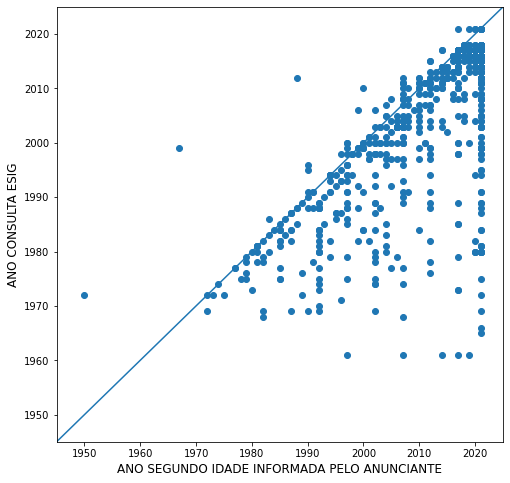

In [105]:
import matplotlib.pyplot as plt

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=12)

plt.figure(figsize=(8, 8))
plt.scatter(ano_informado, ano_busca_esig)
plt.xlabel('ANO SEGUNDO IDADE INFORMADA PELO ANUNCIANTE')
plt.ylabel('ANO CONSULTA ESIG')
plt.xlim([1945, 2025])
plt.ylim([1945, 2025])

x = [x for x in range(1945, 2026)]
y = x

plt.plot(x, y)

plt.show()


### FIM EXTRAÇÃO INFORMAÇÕES ANO

In [106]:

start_time = time.time()

d = dict()

descricao = "EDF SAMAMBAIA HELIO FALCÃO 686, APTO. 50278 m2 de área útil106 m2 área totalSala para 2 ambientes (jantar/estar), varanda, circulação interna, dois quartos com armários, um banheiro social com box blindex, cozinha com armários, terraço de serviço com lavanderia, quarto e wcb para empregada, armários nos quartos e cozinha, 1 vaga de garagemEdifício com 1 Elevador, 3 unidades por andar, Antena Coletiva, Estacionamento, Interfone, Jardim interno, Lavanderia, PilotisTipo do imóvel: ApartamentoMetragem útil: 77m²Total dormitórios: 2Total suítes: 0Localização: Boa Viagem | RecifeValor: R$270.000Algumas características:- Banheiro de serviço- Box de vidro- Despensa- Elevador- Gerador Elétrico- Janelas grandes- Litoral- Portaria 24h- Próximo a praia- Sol da manhã- Sol da tarde- Tanque- Tomada 3 pinos- Vista livreAnúncio do corretor de imóveis Ivone Rodrigues De Menezes CRECI: Ver dados"
#descricao = preparar_texto(descricao)
descricao = descricao.upper()
#print(descricao)
result = []
for nome in nomes:
    #d[nome] = nome in descricao
#    d[nome] = calcular_similaridade_novo(nome = nome, texto_tokens = descricao)
#    d[nome] = calcular_similaridade_original(nome = nome, texto = descricao)
    if nome in descricao and nome not in result:
        result.append(nome)
        
    


print("--- %s seconds ---" % (time.time() - start_time))

#dict(sorted(d.items(), reverse=True, key=lambda item: item[1]))
print(result)
data_esig_boa_viagem_residencial.loc[result][['Endereco', 'Ano Construcao', 'Rua', 'Numero']]

--- 0.005002737045288086 seconds ---
['EDF SAMAMBAIA']


,Endereco,Ano Construcao,Rua,Numero
Nome Processado,,,,
EDF SAMAMBAIA,"AVENIDA BOA VIAGEM, 2514, BOA VIAGEM, RECIFE ...",1979,AVENIDA BOA VIAGEM,2514


## Fim da busca por nomes de edifícios

In [107]:
nomes = [nome for nome in nomes if str(nome) != 'nan']

bag_nomes = []
#"""
for nome in nomes:
    nome = str(nome)
    nome = nome.upper()
    nome = unidecode.unidecode(nome)
    tokens = nome.split()
    for termo in tokens:
        if termo not in bag_nomes:
            bag_nomes.append(termo)

#"""
'BAMBU' in bag_nomes
#'DE' not in nomes[0].split()
#print(bag_nomes.sort())

True

### ESPAÇO PARA TESTES DE FUNCIONALIDADES

In [ ]:
a = "DAVI SOUZA ( CORRETTOR CRECI: Ver dados FONE: (81) 9.Ver dados É TAMBÉM WHATSAPP ). EMPREENDIMENTO DO EDIFÍCIO ESTAÇÃO DO MAR ENDEREÇO: AVENIDA BOA VIAGEM Nº 5274, APT. 2301 - BOA VIAGEM - RECIFE - PE CEP: Ver dados O APARTAMENTO: VENDO APARTAMENTO NA AVENIDA BOA VIAGEM O EDIFÍCIO ESTAÇÂO DO MAR, CONSTRUTORA MOURA DUBEUX, ANDAR ALTO! SEMI-DECORADO,C/ 04 SUÍ- TES, C/ 240 M² DE ÁREA ÚTIL, C/ 04 VAGAS DE GARAGEM, SALA P/ 04 AMBIENTES, SALA DE TELEVISÃO, PRÉDIO C/ TODA INFRAESTRUTURA, PIS- CINA, PLAYGROUND, CAMPO DE FUTEBOL, SALÃO DE FESTAS DECORADO E CLIMATIZADO, ACADEMIA, 03 ELEVADORES, 01 P/ ANDAR. DETALHES DO IMÓVEL: TIPO: VENDA - APARTAMENTO PADRÃO CONDOMÍNIO: 1.700,00 REAIS IPTU: R$ 500,00 REAIS AO MÊS ÁREA ÚTIL: 240 M² NÚMERO DE QUARTOS: 04 NÚMERO DE BANHEIROS: 05 OU MAIS VAGAS DE GARAGEM: 04 ÁREA DE SERFVIÇO ARMÁRIOS EMBUTIDOS ARMÁRIOS NA COZINHA MOBILIADO AR CONDICIONADO CHURRASQUEIRA VARANDA ACADEMIA PISCINA QUARTO DE SERVIÇO. DETALHES DO CONDOMÍNIO: CONDOMÍNIO FECHADO ELEVADOR SEGURANÇA 24 HS PORTARIA 24 HS PERMITIDO ANIMAIS ACADEMIA SALÃO DE FESTAS. VALOR DO IMÓVEL..................................................................................: R$ 4.200.000,00 MIL REAIS.".upper()
a = unidecode.unidecode(a)

a = a[a.find("EDIF"):]
a = re.sub('[^A-Za-z0-9]+', ' ', a)

a = a.replace(',', '')
#print(a)

#print(a)
a = a.split()[:6]
#a = word_tokenize(a)[:6] #USAR ESSE
#print(a)

#bag = ['HILSON', 'MACEDO', 'MOTA', 'PROFESSOR', 'CATEDRAL', 'SAO', 'SANTA', 'DE', 'CECILIA', 'MARIA', 'SAMAMBAIA']
result = []
for token in a:
    if token in bag_nomes:
        result.append(token)

result = " ".join(result)
result


In [ ]:
import nltk
nltk.download()


## NLP TESTING

In [ ]:

X = "VENDO APARTAMENTO NA AVENIDA BOA VIAGEM O EDIF ESTACAO DO MAR, CONSTRUTORA MOURA DUBEUX, ANDAR ALTO! SEMI-DECORADO,C/ 04 SUÍ- TES, C/ 240 M² DE ÁREA ÚTIL, C/ 04 VAGAS DE GARAGEM, SALA P/ 04 AMBIENTES, SALA DE TELEVISÃO, PRÉDIO C/ TODA INFRAESTRUTURA, PIS- CINA, PLAYGROUND, CAMPO DE FUTEBOL, SALÃO DE FESTAS DECORADO E CLIMATIZADO, ACADEMIA, 03 ELEVADORES, 01 P/ ANDAR. DETALHES DO IMÓVEL: TIPO: VENDA - APARTAMENTO PADRÃO CONDOMÍNIO: 1.700,00 REAIS IPTU: R$ 500,00 REAIS AO MÊS ÁREA ÚTIL: 240 M² NÚMERO DE QUARTOS".lower()
Y = "EDIF ESTACAO DO MAR".lower()  
X = unidecode.unidecode(X)
Y = unidecode.unidecode(Y)
X = X[X.find("EDIF".lower()):]
X = re.sub('[^A-Za-z0-9]+', ' ', X)
#print(X)

x = re.findall('EDIF|EDF|ED.', s)
if len(x) > 0:
    x = x[0]
    s = s[s.find(x):]#.split()[:6]


# tokenization
X_list = word_tokenize(X)#[:7]
Y_list = word_tokenize(Y)

#print(X_list)
  
# sw contains the list of stopwords
sw = stopwords.words('portuguese') 
l1 =[];l2 =[]
  
# remove stop words from the string
X_set = {w for w in X_list if not w in sw} 
Y_set = {w for w in Y_list if not w in sw}



# form a set containing keywords of both strings 
rvector = X_set.union(Y_set) 
for w in rvector:
    if w in X_set: l1.append(1) # create a vector
    else: l1.append(0)
    if w in Y_set: l2.append(1)
    else: l2.append(0)
c = 0
  
# cosine formula 
for i in range(len(rvector)):
        c+= l1[i]*l2[i]
cosine = c / float((sum(l1)*sum(l2))**0.5)
print("similarity: ", cosine)

In [ ]:
import re

s = "lANÇAMENTO DO ED. MIRANTE AVENIDA BOA VIAGEM Nº 5274 - PE CEP:VENDO APARTAMENTO NA AVENIDA BOA VIAGEM DUBEUX, ANDAR ALTO! SEMI-DECORADO,C/ 04 SUÍ- TES, C/ 240 M² DE ÁREA ÚTIL, C/ 04 VAGAS DE GARAGEM, SALA P/ 04 AMBIENTES, SALA DE TELEVISÃO, PRÉDIO C/ TODA INFRAESTRUTURA, PIS- CINA, PLAYGROUND, CAMPO DE FUTEBOL, SALÃO DE FESTAS DECORADO E CLIMATIZADO, ACADEMIA, 03 ELEVADORES, 01 P/ ANDAR. DETALHES DO IMÓVEL: TIPO: VENDA - APARTAMENTO PADRÃO CONDOMÍNIO: 1.700,00 REAIS IPTU: R$ 500,00 REAIS AO MÊS ÁREA ÚTIL: 240 M² NÚMERO DE QUARTOS: 04 NÚMERO DE BANHEIROS: 05 OU MAIS VAGAS DE GARAGEM: 04 ÁREA DE SERFVIÇO ARMÁRIOS EMBUTIDOS ARMÁRIOS NA COZINHA MOBILIADO AR CONDICIONADO CHURRASQUEIRA VARANDA ACADEMIA PISCINA QUARTO DE SERVIÇO. DETALHES DO CONDOMÍNIO: CONDOMÍNIO FECHADO ELEVADOR R$ 4.200.000,00 MIL REAIS.".upper()
x = re.findall('EDIF|EDF|ED.', s)
if len(x) > 0:
    x = x[0]
    s = s[s.find(x):]#.split()[:6]
   
    
print(s)



In [ ]:
a = "paulo edif. edific led edificacao edificio ed. edif edf edif. edif edf. ed. edif ed. edificio"
a = a.replace('ed.', 'edf')
a = re.sub('[.]+', '', a)#a.replace('.', '')
re.sub('edificio|edif |edf ', 'EDF ', a)

In [ ]:
texto = "edif. paulo fagner rua joão sales de menezes"
calcular_similaridade(nome = 'null', texto = texto)

In [ ]:
d = {'a':[x for x in range(10)], 'b':[x for x in range(10)]}
d
df = pd.DataFrame(d)
df.a = df.a**2
#df['c'] = ['paulo -fágner 11', 'edf. ciÇa', 'fabiane - andreza', 'pauli..']
#df['c'] = df.c.apply(remover_caracteres_especiais_e_acentuacao)
#df2 = df[df['a'] < 4].copy()
df['a'] = df['a'].astype('object')
df.dtypes

In [ ]:
a = ['EDF FERNANDO DA FONTE II NOVO', 'EDF FERNANDO DA FONTE', 'EDF FERNANDO DA FONTE II']
np.argmax([len(x.split()) for x in a])

In [ ]:
#df2.loc['CICA']
#df2
#df.at[0, 'a'] = [99, 98, 97]
#df.iloc[0,0] = [99, 98, 97]
df


In [ ]:
df = pd.DataFrame({'c1': [10, 11, 12], 'c2': [100, 110, 120]})
#df = df.reset_index()  # make sure indexes pair with number of rows

#for index, row in df.iterrows():
    #print(row['c1'], row['c2'])
    #print(row['c1'])

In [ ]:
df2 = df.copy()

In [ ]:
df2['nome'] = ['paulo', 'fabiane', 'pauline']

In [ ]:
df2

In [ ]:
#df2.set_index(['c1', 'nome'], drop = False, inplace = True)
df2 = df2.set_index(['c1','nome']).unstack().swaplevel(0,1,1).sort_index(1)

In [ ]:
df2.loc['paulo']

In [ ]:
index

In [ ]:
df = pd.DataFrame(
    [[21, 'paulo', 72, 67],
    [23, 'pauline', 78, 69],
    [23, 'fabiane', 74, 56],
    [52, 'paulo', 54, 76]],
    columns=['rollno','name', 'physics', 'botony'])

df = df.set_index(['name'],  drop = False)

#print(df)

#print('\nDataFrame with MultiIndex\n',df)
(df.loc['as'])



## TESTES DATA FRAMES

In [ ]:
[type(a) is int for a in data_aptos_aux2['ano busca']]

In [ ]:
#data_aptos_clear.quantile(.97)['PU']

In [ ]:
data_aptos_aux2[ (data_aptos_aux2['ano segundo anuncio'].notnull()) & ([type(a) is int for a in data_aptos_aux2['ano busca']]) ]

In [ ]:
num = 'paulo.'
#num.replace('.0', '')
num[:num.find(".")]


In [ ]:
#Concatenando Data Frames
import pandas as pd

df_a = pd.DataFrame({'a':[1, 11, 111, 1111], 'b':[2, 22, 222, 2222]})
#display(df_a)
df_b = pd.DataFrame({'a':[1, 11, 111, 3333], 'b':[2, 22, 222, 4444]})
#display(df_b)
df = pd.concat([df_a, df_b], ignore_index=True)
df['ano'] = 2022
display(df)
#i = 111

#selecionando condição para alteração em data frame
i = [1, 111]
for x in i:
    df.loc[df['a'] == x, ['b', 'ano']] = ['-99', '1999']

#    df.loc[df['a'] == -999999, ['b', 'ano']] = -77777777#[['a', 'b']]
display(df.loc[df['b'] == 4444][['ano']])
#df['b'].astype('int4') - df['a'].astype('int64')


## Outros testes 

In [ ]:
a = "paulo   fagner     tenorio"
re.sub('\s+',' ', a)

In [ ]:
[type(a) is int for a in data_aptos_aux2['ano busca']]

In [ ]:
texto = '      paulo fagner 1980 #$% 9 @...,-         '
texto.strip()

In [ ]:
endereco = "rua marques de valenca - 320,,,boa viage"
get_numero(endereco)

In [ ]:
rua = ' R Maria Carolina, 586 - Boa Viagem R,  Boa Viagem, Recife'.upper().strip()
if rua.find('R ') == 0:
    rua = rua.replace('R ', 'RUA ')

rua

### Testes remoção atributos

In [ ]:
df = pd.DataFrame({'nome':['paulo', 'fabiane', 'pauline', 'paulo'], 'idade': [41, 42, 6, 41], 'pontos': [100, 110, 120, 100]})
#print(df.drop_duplicates(subset = ['nome', 'idade']))
#print(df)
df.drop(columns=['nome'], inplace=True)
df

In [ ]:
rua = 'Rua luis Souza de morais'.upper()
get_homofonos(rua)

FUNÇÕES ORIGINAIS DE SIMILARIDADE

In [ ]:
def preparar_texto(texto):    
    Y = texto.lower()  
    Y = unidecode.unidecode(Y)    
    Y = Y.replace('ed.', 'edf')
    Y = re.sub('[.]+', '', Y)
    Y = re.sub('edificio|edif |edf ', 'edf ', Y)

    posicao = Y.find('edf ')
    if posicao > -1:
        Y = Y[posicao:]

    Y = re.sub('[^A-Za-z0-9]+', ' ', Y)
    
    
    if len(Y) <= 1:
        Y = 'nulo'
        
    Y_list = word_tokenize(Y)
    
    cut = len(Y_list)
    if len(Y_list) > 6 and posicao >-1:
        cut = 6
    
    Y_list = Y_list[:cut]
    
    return Y_list




def calcular_similaridade_novo(nome, texto_tokens):
    X = nome.lower()
   # Y = texto
    X = unidecode.unidecode(X)

    X = re.sub('[^A-Za-z0-9]+', ' ', X)
    
    if len(X) <= 1:
        X = 'null'
    
    # tokenization
    X_list = word_tokenize(X)
    
    Y_list = texto_tokens

    # sw contains the list of stopwords
    sw = stopwords.words('portuguese') 
    l1 =[];l2 =[]

    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw}

    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0

    # cosine formula 
    for i in range(len(rvector)):
            c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    #print("similarity: ", cosine)
    return cosine


def calcular_similaridade_original(nome, texto):
    X = nome.lower()
    Y = texto.lower()  
    X = unidecode.unidecode(X)
    Y = unidecode.unidecode(Y)
    
    Y = Y.replace('ed.', 'edf')
    Y = re.sub('[.]+', '', Y)
    Y = re.sub('edificio|edif |edf ', 'edf ', Y)

    aux_s = Y.find('edf ')#re.findall('edif|edf|ed.', Y)
    if aux_s > -1:
        #aux_s = aux_s[0]
        Y = Y[aux_s:]

    Y = re.sub('[^A-Za-z0-9]+', ' ', Y)
    X = re.sub('[^A-Za-z0-9]+', ' ', X)
    
    if len(X) <= 1:
        X = 'null'
    
    if len(Y) <= 1:
        Y = 'nulo'

    # tokenization
    X_list = word_tokenize(X)
    Y_list = word_tokenize(Y)
    
    cut = len(Y_list)
    if len(Y_list) > 6 and aux_s >-1:
        cut = 6
    
    Y_list = Y_list[:cut]

    # sw contains the list of stopwords
    sw = stopwords.words('portuguese') 
    l1 =[];l2 =[]

    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw}

    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0

    # cosine formula 
    for i in range(len(rvector)):
            c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    #print("similarity: ", cosine)
    return cosine
    